In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)



Tensorflow 2.8.0


In [2]:
import cv2
import numpy as np
import os 
path_train="C:/Users/yanti/Desktop/06ok/"
path_test="C:/Users/yanti/Desktop/06ng/"
dirs=os.listdir(path_train)
dirs1=os.listdir(path_test)

train_x=[]
for i in dirs:    
    img = cv2.imread(path_train+i)
    train_x.append(img)

    
train_y=[]
for i in range(len(train_x)):
    train_y.append(0)

    
test_x=[]
for i in dirs1:    
    img = cv2.imread(path_test+i)
    test_x.append(img)
test_y=[]
for i in range(len(dirs1)):
    if "(NG)" in dirs1[i]:
        test_y.append(1)                    
    else: 
        test_y.append(0)

In [3]:
batch_size = 64
width = 64
height = 64
channel=3
image_shape = (width, height, 3)

def preprocess(features):
    for i in range(len(features)):
        features[i]=cv2.resize(features[i], image_shape[:2])
    image =features    
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    return image


In [4]:
train_x=preprocess(train_x)

dataset = tf.data.Dataset.from_tensor_slices(train_x)
dataset =dataset.shuffle(len(train_x))
dataset=dataset.batch(batch_size, drop_remainder=True).repeat()

Step 0: g_loss -1.5713 critic_loss -3.5383 critic fake -0.0138  critic_real -3.5928 penalty 0.0683


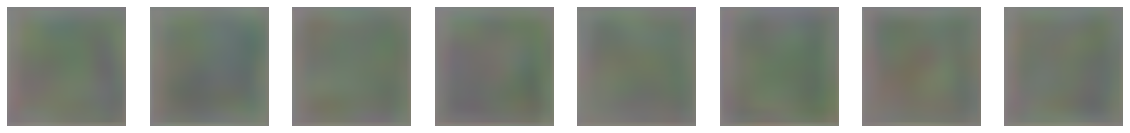

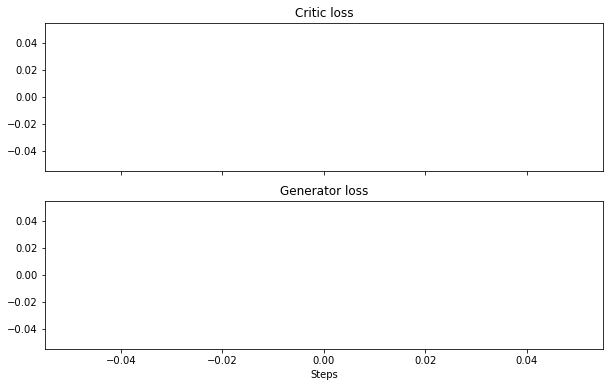

Step 100: g_loss -7.8286 critic_loss -13.9157 critic fake -11.6047  critic_real -6.7667 penalty 4.4557


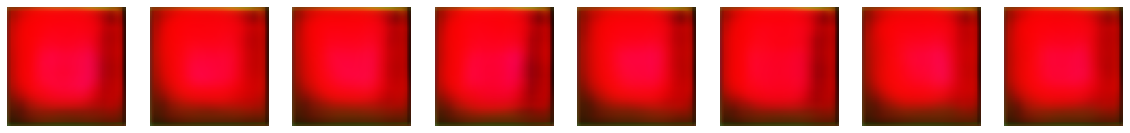

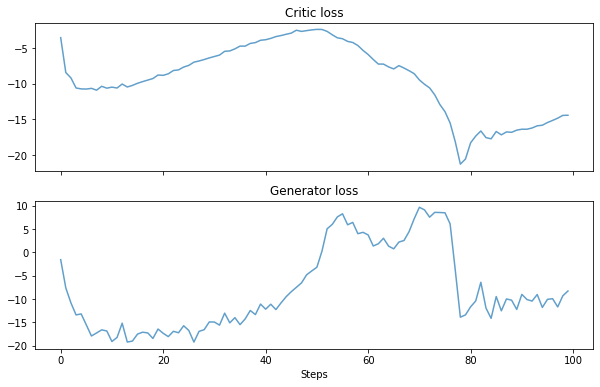

Step 200: g_loss -3.0316 critic_loss -3.0825 critic fake 0.5762  critic_real -3.8623 penalty 0.2037


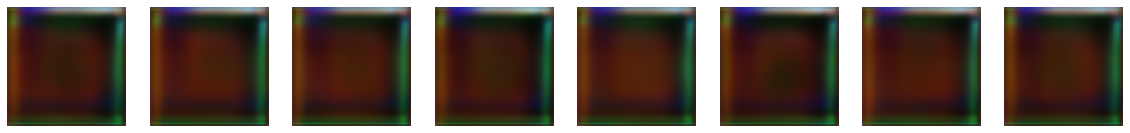

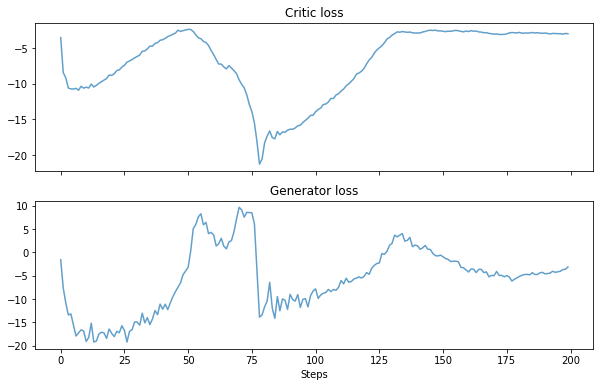

Step 300: g_loss 2.2264 critic_loss -5.6319 critic fake -8.5774  critic_real 2.0133 penalty 0.9323


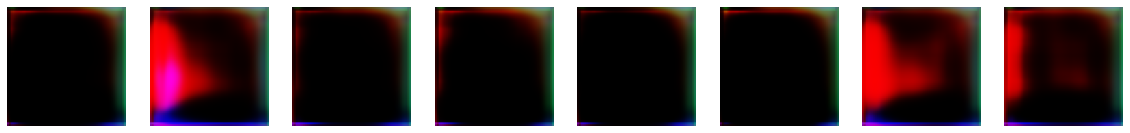

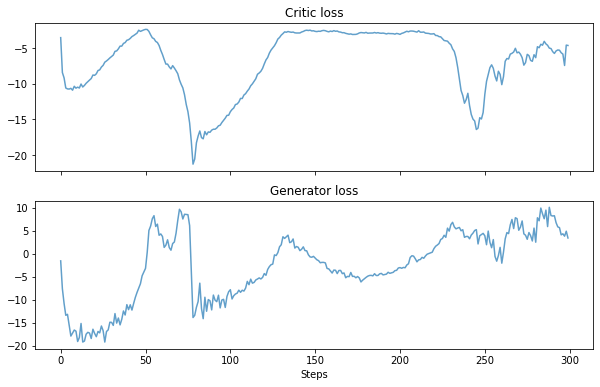

Step 400: g_loss 7.1061 critic_loss -4.0135 critic fake -6.6623  critic_real 2.5195 penalty 0.1293


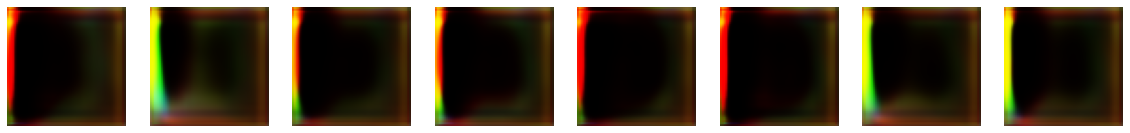

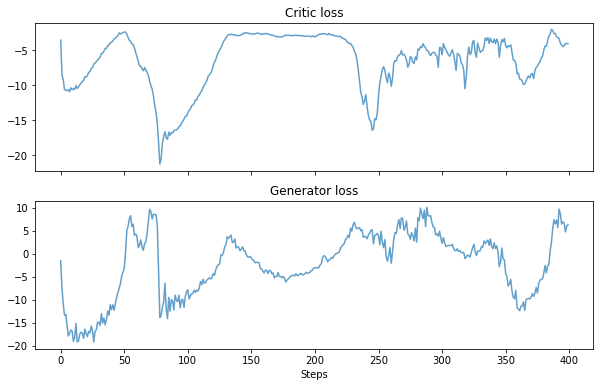

Step 500: g_loss -1.8182 critic_loss -1.9681 critic fake 0.7717  critic_real -2.9059 penalty 0.1661


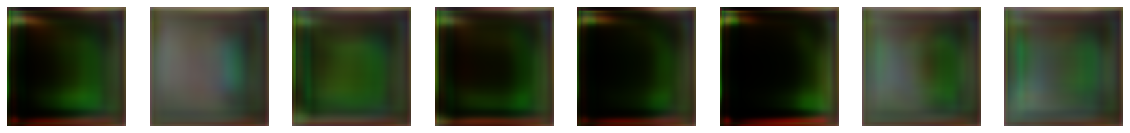

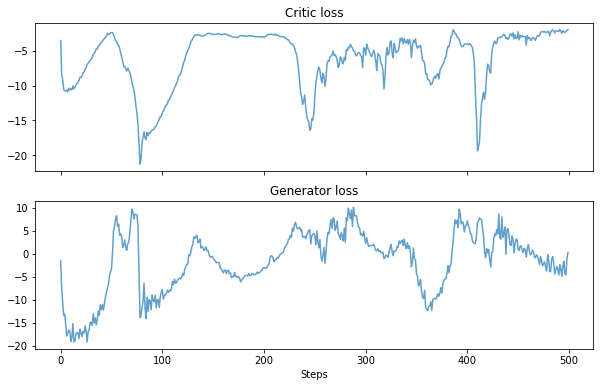

Step 600: g_loss -3.1699 critic_loss -1.7365 critic fake 0.4651  critic_real -2.2504 penalty 0.0488


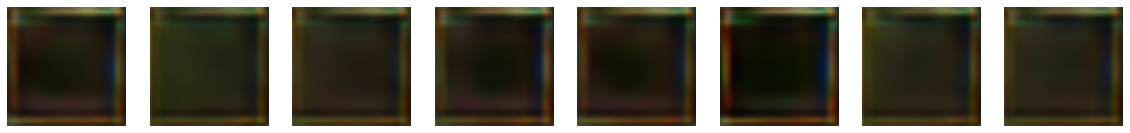

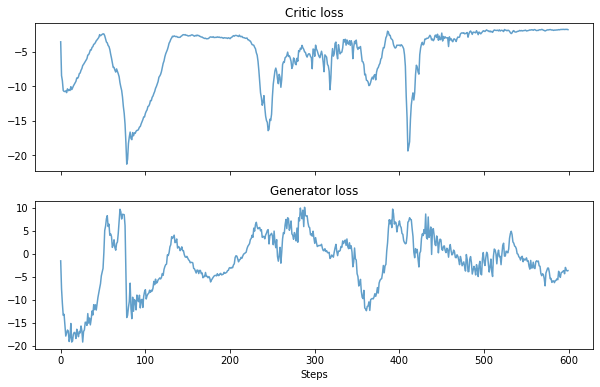

Step 700: g_loss -2.6842 critic_loss -8.6733 critic fake -5.4249  critic_real -4.8608 penalty 1.6124


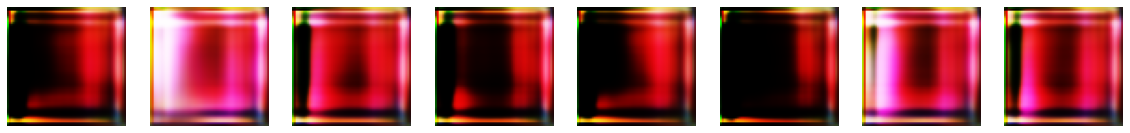

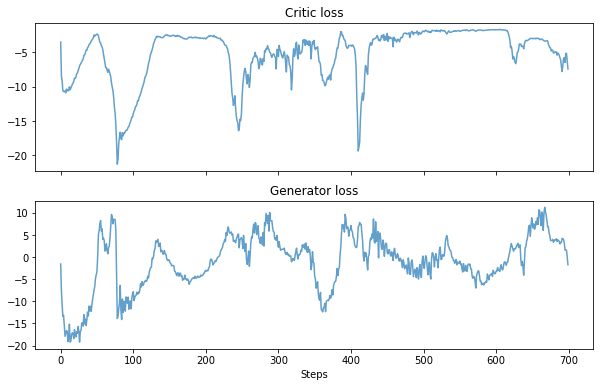

Step 800: g_loss -10.2681 critic_loss -10.6690 critic fake -6.0446  critic_real -5.6105 penalty 0.9861


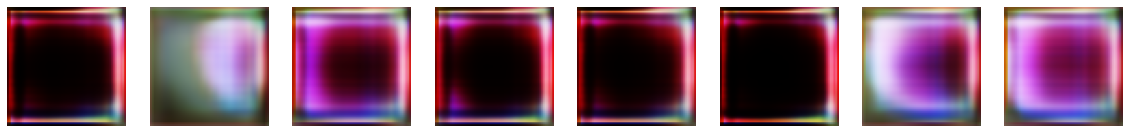

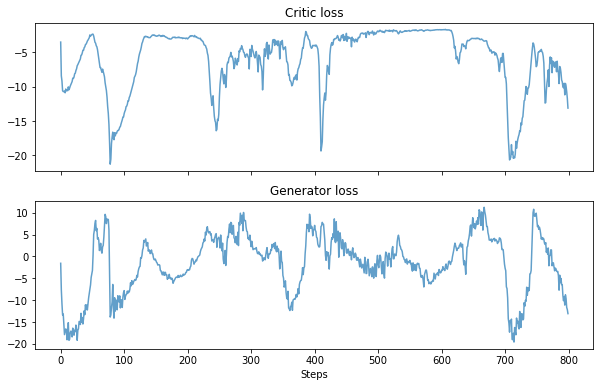

Step 900: g_loss -3.2524 critic_loss -2.5484 critic fake 4.7624  critic_real -7.4044 penalty 0.0936


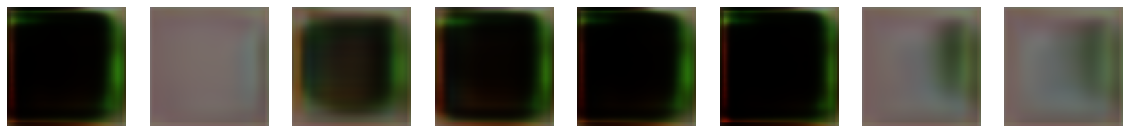

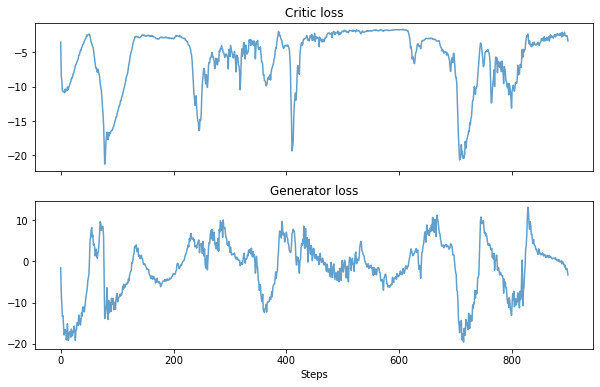

Step 1000: g_loss -9.7596 critic_loss -3.6416 critic fake 3.6024  critic_real -7.4584 penalty 0.2144


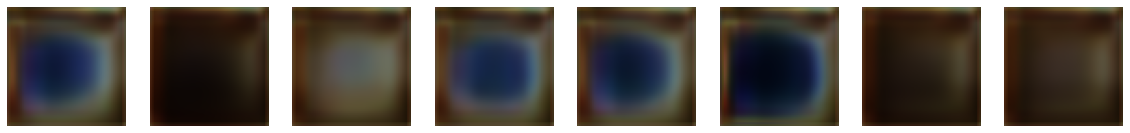

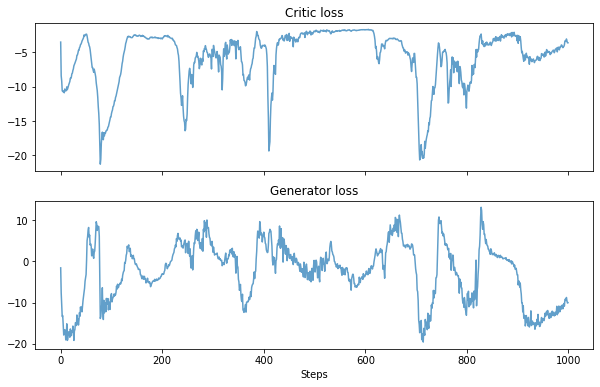

Step 1100: g_loss 11.8106 critic_loss -3.3924 critic fake -12.3189  critic_real 8.6092 penalty 0.3173


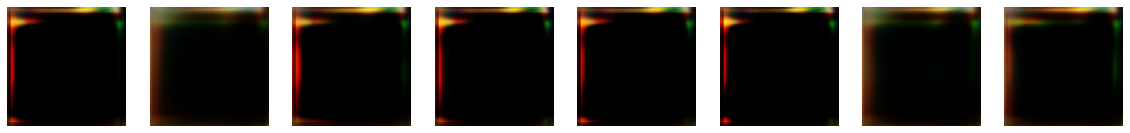

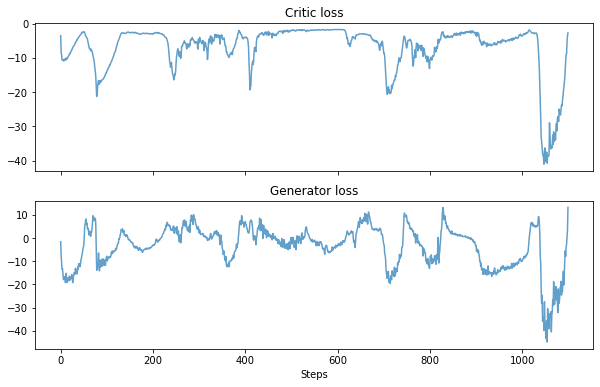

Step 1200: g_loss -14.1607 critic_loss -4.9141 critic fake 5.3426  critic_real -10.6175 penalty 0.3609


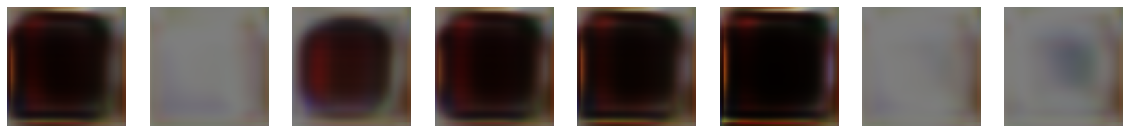

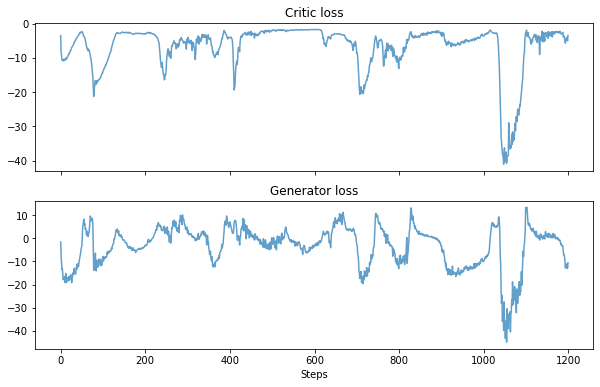

Step 1300: g_loss -1.1032 critic_loss -2.2937 critic fake -1.0768  critic_real -1.4284 penalty 0.2115


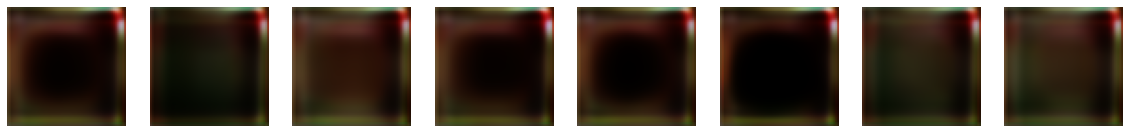

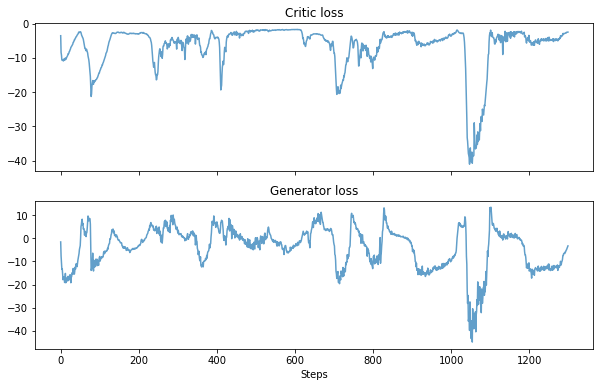

Step 1400: g_loss -10.0832 critic_loss -13.6551 critic fake -9.6962  critic_real -7.4434 penalty 3.4845


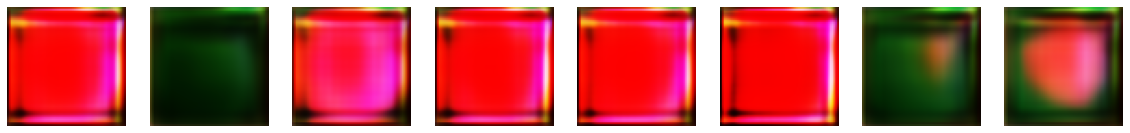

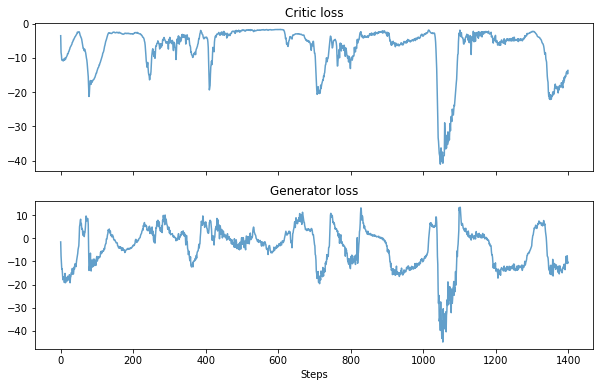

Step 1500: g_loss -5.5652 critic_loss -2.7610 critic fake 4.8834  critic_real -7.9133 penalty 0.2689


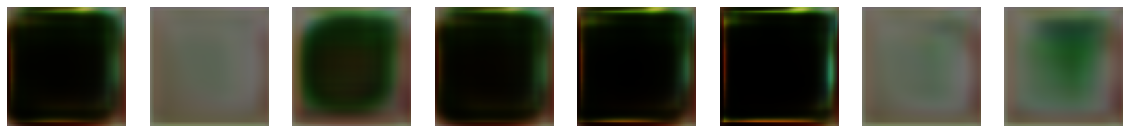

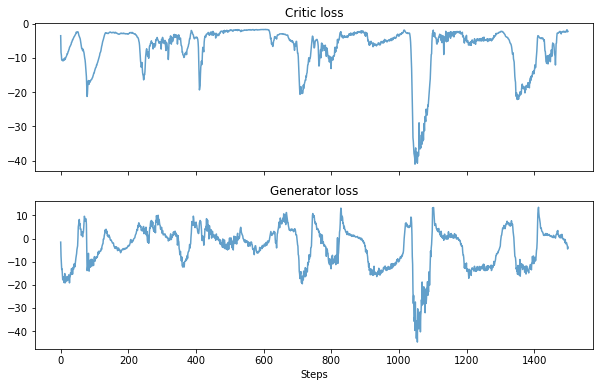

Step 1600: g_loss -3.6020 critic_loss -2.1171 critic fake 1.1329  critic_real -3.3366 penalty 0.0866


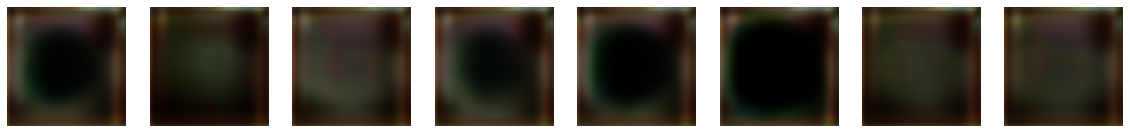

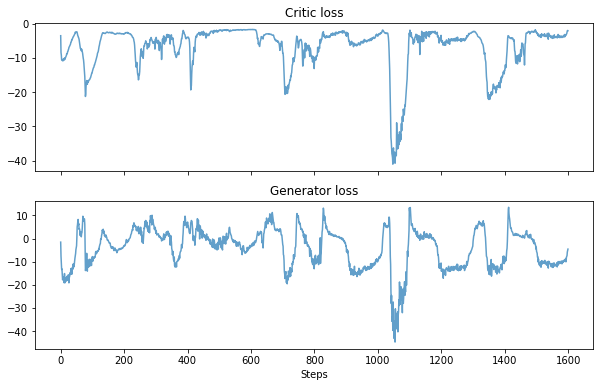

Step 1700: g_loss -3.5661 critic_loss -2.9759 critic fake 0.4142  critic_real -3.6361 penalty 0.2460


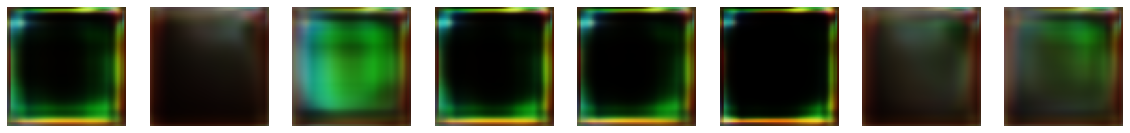

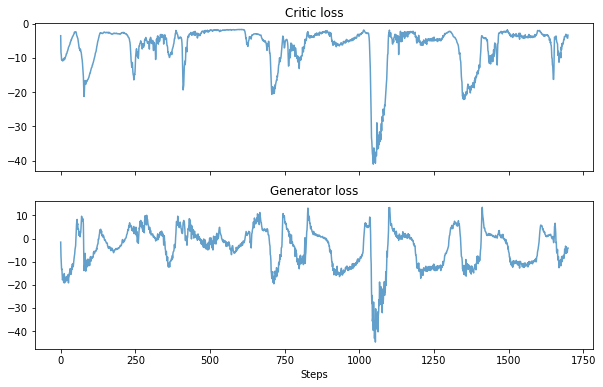

Step 1800: g_loss -11.5144 critic_loss -3.9636 critic fake 6.1465  critic_real -10.5551 penalty 0.4450


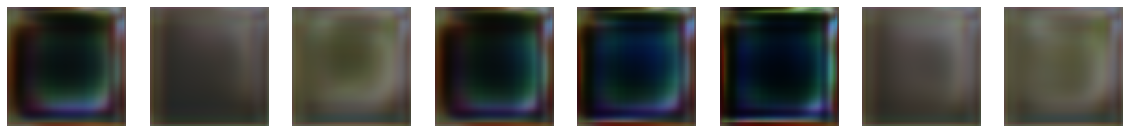

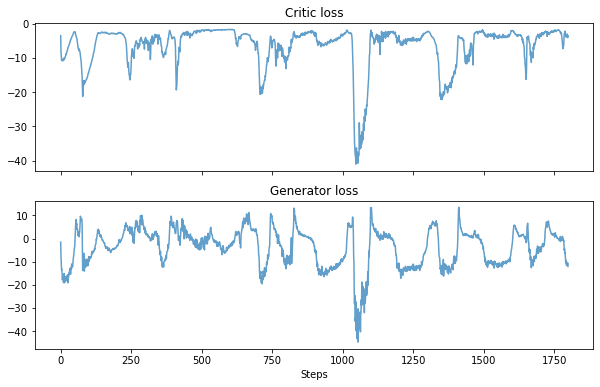

Step 1900: g_loss 0.4607 critic_loss -1.7701 critic fake -2.9475  critic_real 1.1082 penalty 0.0692


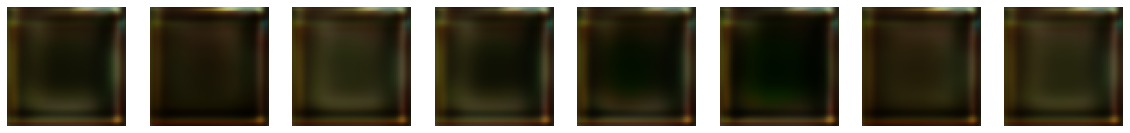

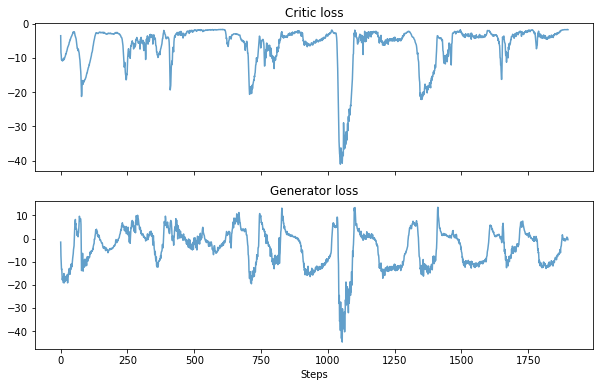

Step 2000: g_loss -2.5799 critic_loss -3.4305 critic fake -0.0846  critic_real -3.5994 penalty 0.2535


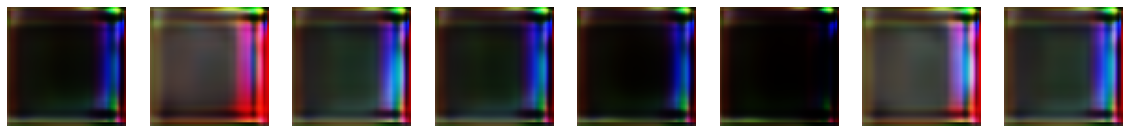

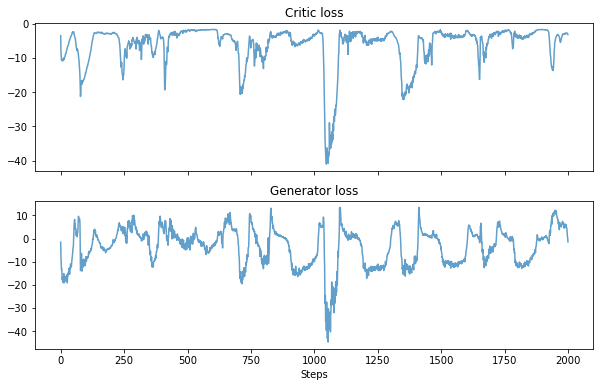

Step 2100: g_loss 0.9272 critic_loss -7.3393 critic fake -4.6972  critic_real -3.5744 penalty 0.9322


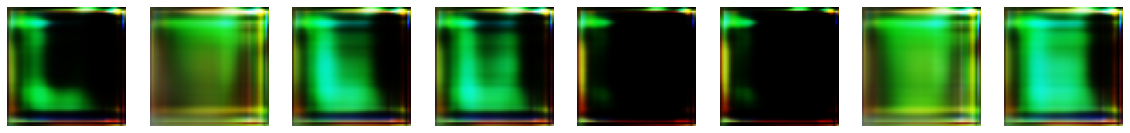

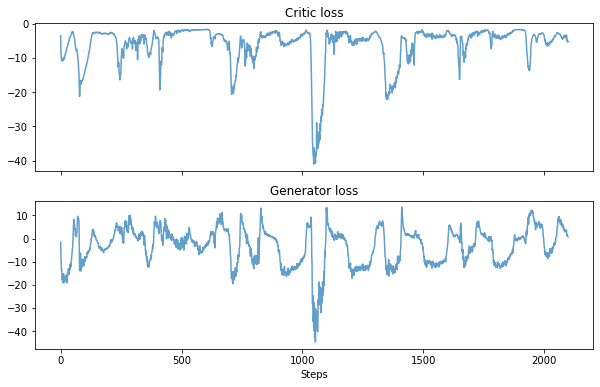

Step 2200: g_loss 4.5522 critic_loss -3.4800 critic fake -8.3419  critic_real 4.6117 penalty 0.2502


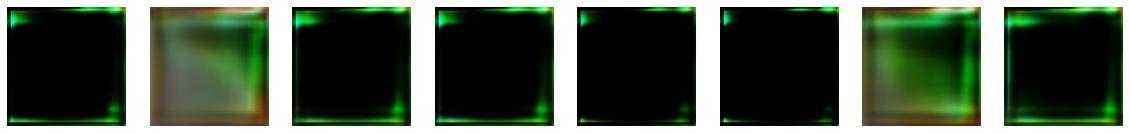

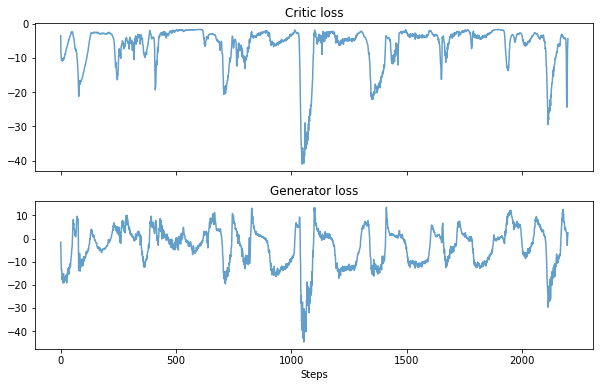

Step 2300: g_loss -14.6070 critic_loss -6.6718 critic fake 2.7788  critic_real -9.8175 penalty 0.3669


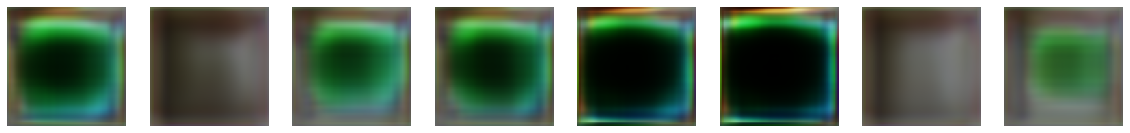

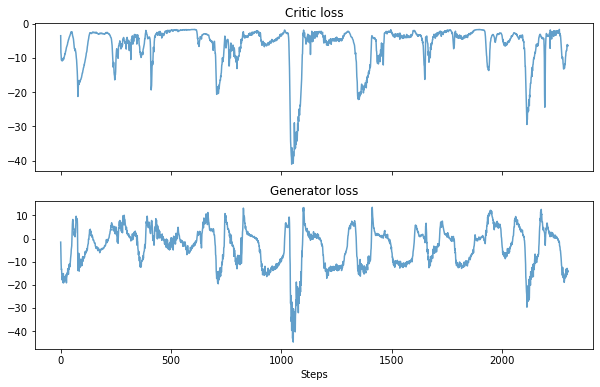

Step 2400: g_loss 2.0851 critic_loss -3.2325 critic fake -11.1350  critic_real 7.5115 penalty 0.3910


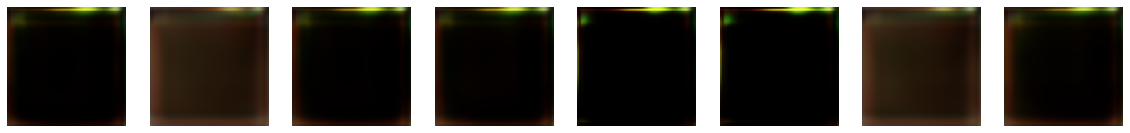

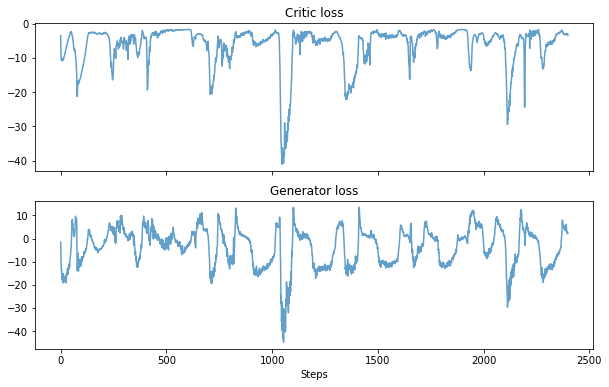

Step 2500: g_loss -12.6234 critic_loss -4.3846 critic fake 5.4055  critic_real -10.0856 penalty 0.2956


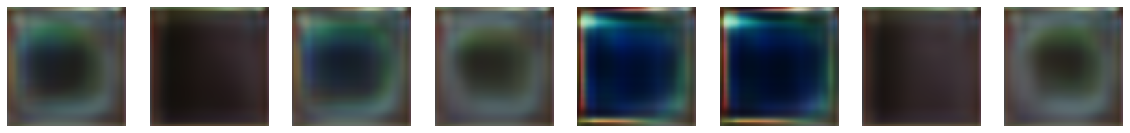

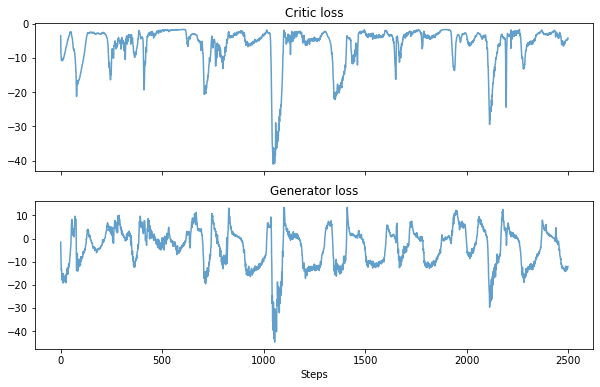

In [ ]:
class WGAN_GP():
    def __init__(self,input_shape):
        self.z_dim=128
        self.input_shape=input_shape
        
        self.loss_critic= {}      #判別全部
        self.loss_generator = {}    #生成全部 
        
        
        
        #critic
        self.n_critic=5 #訓練幾次critic
        self.penalty_const=10 
        self.critic=self.build_critic()
        self.critic.trainable=False
        self.opt_critic=tf.optimizers.Adam(1e-4,0.5,0.9)
        
        #generator
        self.generator=self.build_generator()
        critic_output = self.critic(self.generator.output) #creat input of generator
        self.model=Model(self.generator.input,critic_output)
        self.model.compile(loss=self.w_loss,optimizer=tf.optimizers.Adam(1e-4, 0.5, 0.9))
        
    def w_loss(self,y_true,y_pred):
        
        w_loss=-tf.reduce_mean(y_true*y_pred)
        
        return w_loss
    
    def build_generator(self):
        
        DIM = 128
        model = Sequential([
            layers.Input(shape=[self.z_dim]),
            
            layers.Dense(4*4*4*DIM),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Reshape((4,4,4*DIM)),

            layers.UpSampling2D((2,2), interpolation='bilinear'),
            layers.Conv2D(2*DIM, 5, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            layers.UpSampling2D((2,2), interpolation='bilinear'),
            layers.Conv2D(2*DIM, 5, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            layers.UpSampling2D((4,4), interpolation='bilinear'),
            layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')],name='Generator')

        return model
    
    
    def build_critic(self):

        DIM = 128
        model = Sequential([
            layers.Input(shape=self.input_shape),

            layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False),
            layers.LeakyReLU(0.2),

            layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False),
            layers.LeakyReLU(0.2),

            layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False),
            layers.LeakyReLU(0.2),

            layers.Flatten(),
            layers.Dense(1)], name='critics')

        return model
    
    def gradient_loss(self,grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1, len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        loss = self.penalty_const * loss
        return loss
        
    def train_critic(self, real_images, batch_size):
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)

        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input)

        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)

            # calculate losses
            loss_fake = self.w_loss(fake_labels, pred_fake)
            loss_real = self.w_loss(real_labels, pred_real)

            # gradient penalty
            epsilon = tf.random.uniform((batch_size, 1, 1, channel))
            interpolates = epsilon * real_images + (1-epsilon) * fake_images
            gradient_tape.watch(interpolates)

            critic_interpolates = self.critic(interpolates)
            gradients_interpolates = gradient_tape.gradient(critic_interpolates, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_interpolates)

            # total loss
            total_loss = loss_fake + loss_real + gradient_penalty

            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.variables)

            self.opt_critic.apply_gradients(zip(gradients, self.critic.variables))
        return loss_fake, loss_real, gradient_penalty

        
    def train(self,data_generator,batch_size,steps,interval=100):
        val_g_input=tf.random.normal((batch_size,self.z_dim))
        real_labels=tf.ones(batch_size)
        
        for i in range(steps):
            for _ in range(self.n_critic):
                try:
                    real_images = next(data_generator)
                except StopIteration:
                    continue
                loss_fake, loss_real, gradient_penalty = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real + gradient_penalty
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} critic_loss {:.4f} critic fake {:.4f}  critic_real {:.4f} penalty {:.4f}".format(i, g_loss, critic_loss, loss_fake, loss_real, gradient_penalty)
                print(msg)

                fake_images = self.generator.predict(val_g_input)
                self.plot_images(fake_images)
                self.plot_losses()
            
            self.loss_critic[i] = critic_loss.numpy()
            self.loss_generator[i] = g_loss
                
    def plot_images(self, images):   
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2.5, grid_row*2.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1]==1:
                    axarr[col].imshow(images[col,:,:,0]*0.5+0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5+0.5)
                axarr[col].axis('off') 
        plt.show()
    def plot_losses(self):
        fig, (ax1, ax2) = plt.subplots(2, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critic loss', alpha=0.7)
        ax1.set_title("Critic loss")
        ax2.plot(list(self.loss_generator.values()), label='Generator loss', alpha=0.7)
        ax2.set_title("Generator loss")

        plt.xlabel('Steps')
        plt.show()

        
wgan = WGAN_GP(image_shape)
wgan.train(iter(dataset), batch_size, 10000, 100)

wgan.model.summary()

wgan.critic.summary()

z = tf.random.normal((100, 128))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)

In [ ]:
def loss_l2( a, b, reduce=None):
    distance = tf.reduce_sum(tf.math.sqrt(tf.math.square(a - b) + 1e-9), axis=reduce)
    return distance

In [ ]:
e_model_izi = Sequential([
    
            layers.Input(shape=(height, width, channel)),
            layers.Conv2D(8, (7,7), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2'),
            layers.Conv2D(16, (5,5), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2'),
            layers.Conv2D(128, (5,5), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2'),
            layers.GlobalAveragePooling2D(name='encoder_output')
        ],name='encoder')

e_model_izi.summary()

In [ ]:
z_ziz = tf.random.normal((100, 128))
dim_n = height * width * channel
dim_k = 128
w_factor = 0.1

g_model=wgan.generator
g_model.trainable=False

d_model=wgan.critic
d_model.trainable=False



steps=10000

for i in range(steps):
    with tf.GradientTape() as tape:


    
        z_hat1=e_model_izi(train_x)
        g_e_image=g_model(z_hat1)
        
        loss_izi=tf.reduce_mean(loss_l2( train_x, g_e_image, [1, 2, 3]) * (1/dim_n))
        
        z_ziz = tf.random.normal((8, 128))
        g_image=g_model(z_ziz)
        z_hat=e_model_izi(g_image)
    
        loss_ziz = tf.reduce_mean(loss_l2(z_ziz, z_hat, [1]) * (w_factor / dim_k))
        
    
        d_real=d_model(train_x)
        d_fake=d_model(g_e_image)
        loss_d=tf.reduce_mean(loss_l2( d_real, d_fake) * (1/ dim_k))
        
        loss_encoder=loss_ziz+ loss_izi
    
        gradients = tape.gradient(loss_encoder, e_model_izi.variables)
        tf.optimizers.Adam(1e-4).apply_gradients(zip(gradients,e_model_izi.variables))
        
        if i%100== 0:
            msg = "Step {}: loss_ziz {:.4f} loss_izi {:.4f} loss_encoder {:.4f} loss_d {:.4f} ".format(i, loss_ziz, loss_izi, loss_encoder,loss_d)
            print(msg)

In [ ]:
test_x=preprocess(test_x)

In [ ]:
z_hat1=e_model_izi.predict(test_x)
g_e_image=g_model.predict(z_hat1)
loss_izi=(loss_l2( test_x, g_e_image, [1, 2, 3]) * (1/dim_n))

z_ziz = tf.random.normal((len(test_x), 128))
g_image=g_model.predict(z_ziz)
z_hat=e_model_izi.predict(g_image)
loss_ziz = (loss_l2(z_ziz, z_hat, [1]) * (w_factor / dim_k))
               
loss_encoder=loss_ziz+ loss_izi

In [ ]:
score=loss_encoder

In [ ]:
#test_y=[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(range(len(test_x)), score, c=['skyblue' if x ==0 else 'pink' for x in test_y])